In [35]:
import networkx as nx
#print(nx.__version__)
import csv
import community
import pandas as pd
from itertools import combinations
from matplotlib import pyplot as plt
#create an empty graph
G = nx.Graph()

In [36]:
# Open the CSV file and read the data for languages
with open('dataset/languages.csv', 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0: # Skip the header columns
            continue
        # Add the language node to graph with green color
        G.add_node(row[0], language=row[1], color='#30FBD0')

In [37]:
#create nodes and edges bewtween repositories and languages
with open('dataset/repos.csv', 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0: # Skip the header columns
            continue
        # transform the string of languages into an array of strings
        row[2], row[5], row[6] = tuple(x.replace(' ', '').replace('[', '').replace(']', '').replace('\'', '').replace('"', '').split(',') for x in (row[2], row[5], row [6]))
        G.add_node(row[0], name=row[1], topics=row[2], n_star=row[3], n_fork=row[4], languages=row[5], p_lang=row[6], color='#5D7EF5')
        # Add the edges between the repository and the languages
        #for lang in row[5]:
         #   G.add_edge(row[0], lang)

In [38]:
# create nodes and edges between users and repositories
with open('dataset/users.csv', 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0: # Skip the header columns
            continue
        # transform the string of repositories into an array of strings
        row[2:4] = [x.replace(' ', '').replace('[', '').replace(']', '').replace('\'', '').replace('"', '').split(',') for x in row[2:4]]
        # Add the user node to graph with blue color
        G.add_node(row[0], name=row[1], repos=row[2], commits= row[3], color='#F8A643')
        # Add edges between the user and their repositories
        #for repo in row[2]:
         #   G.add_edge(row[0], repo)

In [39]:
# Add edges between users and repositories based on the users' list of repositories
for node in list(G.nodes):
    # if it's a user node
    if len(node) >= 1:
        if node[0] == "u":
            # for each repository in the user's list of repositories
            for repo in G.nodes[node]['repos']:
                # add an edge between the user and the repository
                G.add_edge(node, repo)
        if node[0] == "r":
            # for each language in the repository's list of languages
            for lang in G.nodes[node]['languages']:
                # add an edge between the repository and the language
                G.add_edge(node, lang)     

#nx.info(G)

### Degree Centrality of languages 

In [40]:
# Calculate the degree centrality of all nodes
degree_centrality = nx.degree_centrality(G)

# Split the degree centrality for users and repositories
languages_degree_centrality = { k: v for k, v in degree_centrality.items() if k.startswith('l_')}
users_degree_centrality = { k: v for k, v in degree_centrality.items() if k.startswith('u_')}
repos_degree_centrality = { k: v for k, v in degree_centrality.items() if k.startswith('r_')}

# Print the degree centrality of first 10 users in descending order
print("\nDegree centrality of first 5 languages in descending order:")
for node in sorted(languages_degree_centrality, key=languages_degree_centrality.get, reverse=True)[:10]:
    print(node, G.nodes[node]['language'], languages_degree_centrality[node])
    
# Print mean degree centrality for users
print("\nMean degree centrality for languages:", sum(languages_degree_centrality.values())/len(languages_degree_centrality))




Degree centrality of first 5 languages in descending order:
l_0 Ruby 0.48664886515353806
l_1 JavaScript 0.2096128170894526
l_4 Shell 0.0801068090787717
l_8 Python 0.06475300400534045
l_6 C 0.058077436582109475
l_9 C++ 0.03271028037383177
l_10 Perl 0.032042723631508674
l_14 CSS 0.030707610146862484
l_2 HTML 0.030040053404539385
l_3 PHP 0.028037383177570093

Mean degree centrality for languages: 0.013930662128258938


{'l_0': Text(-0.13715992456279705, 0.11931916555674991, 'l_0'),
 'l_1': Text(-0.06295045096258042, -0.42359532319422605, 'l_1'),
 'l_4': Text(0.5023529576251403, -0.16414908795706246, 'l_4'),
 'l_8': Text(0.42991933086364875, -0.4577295669547888, 'l_8'),
 'l_6': Text(0.5724426742165, 0.06300858696933286, 'l_6'),
 'l_9': Text(0.5927217580147882, 0.09547246157382819, 'l_9'),
 'l_10': Text(0.5233703103253756, -0.18001578151373207, 'l_10'),
 'l_14': Text(0.40510614399448486, -0.3027474654925708, 'l_14'),
 'l_2': Text(0.43783226088082755, -0.24187438989663584, 'l_2'),
 'l_3': Text(0.11885541578580298, -0.5636320887068988, 'l_3')}

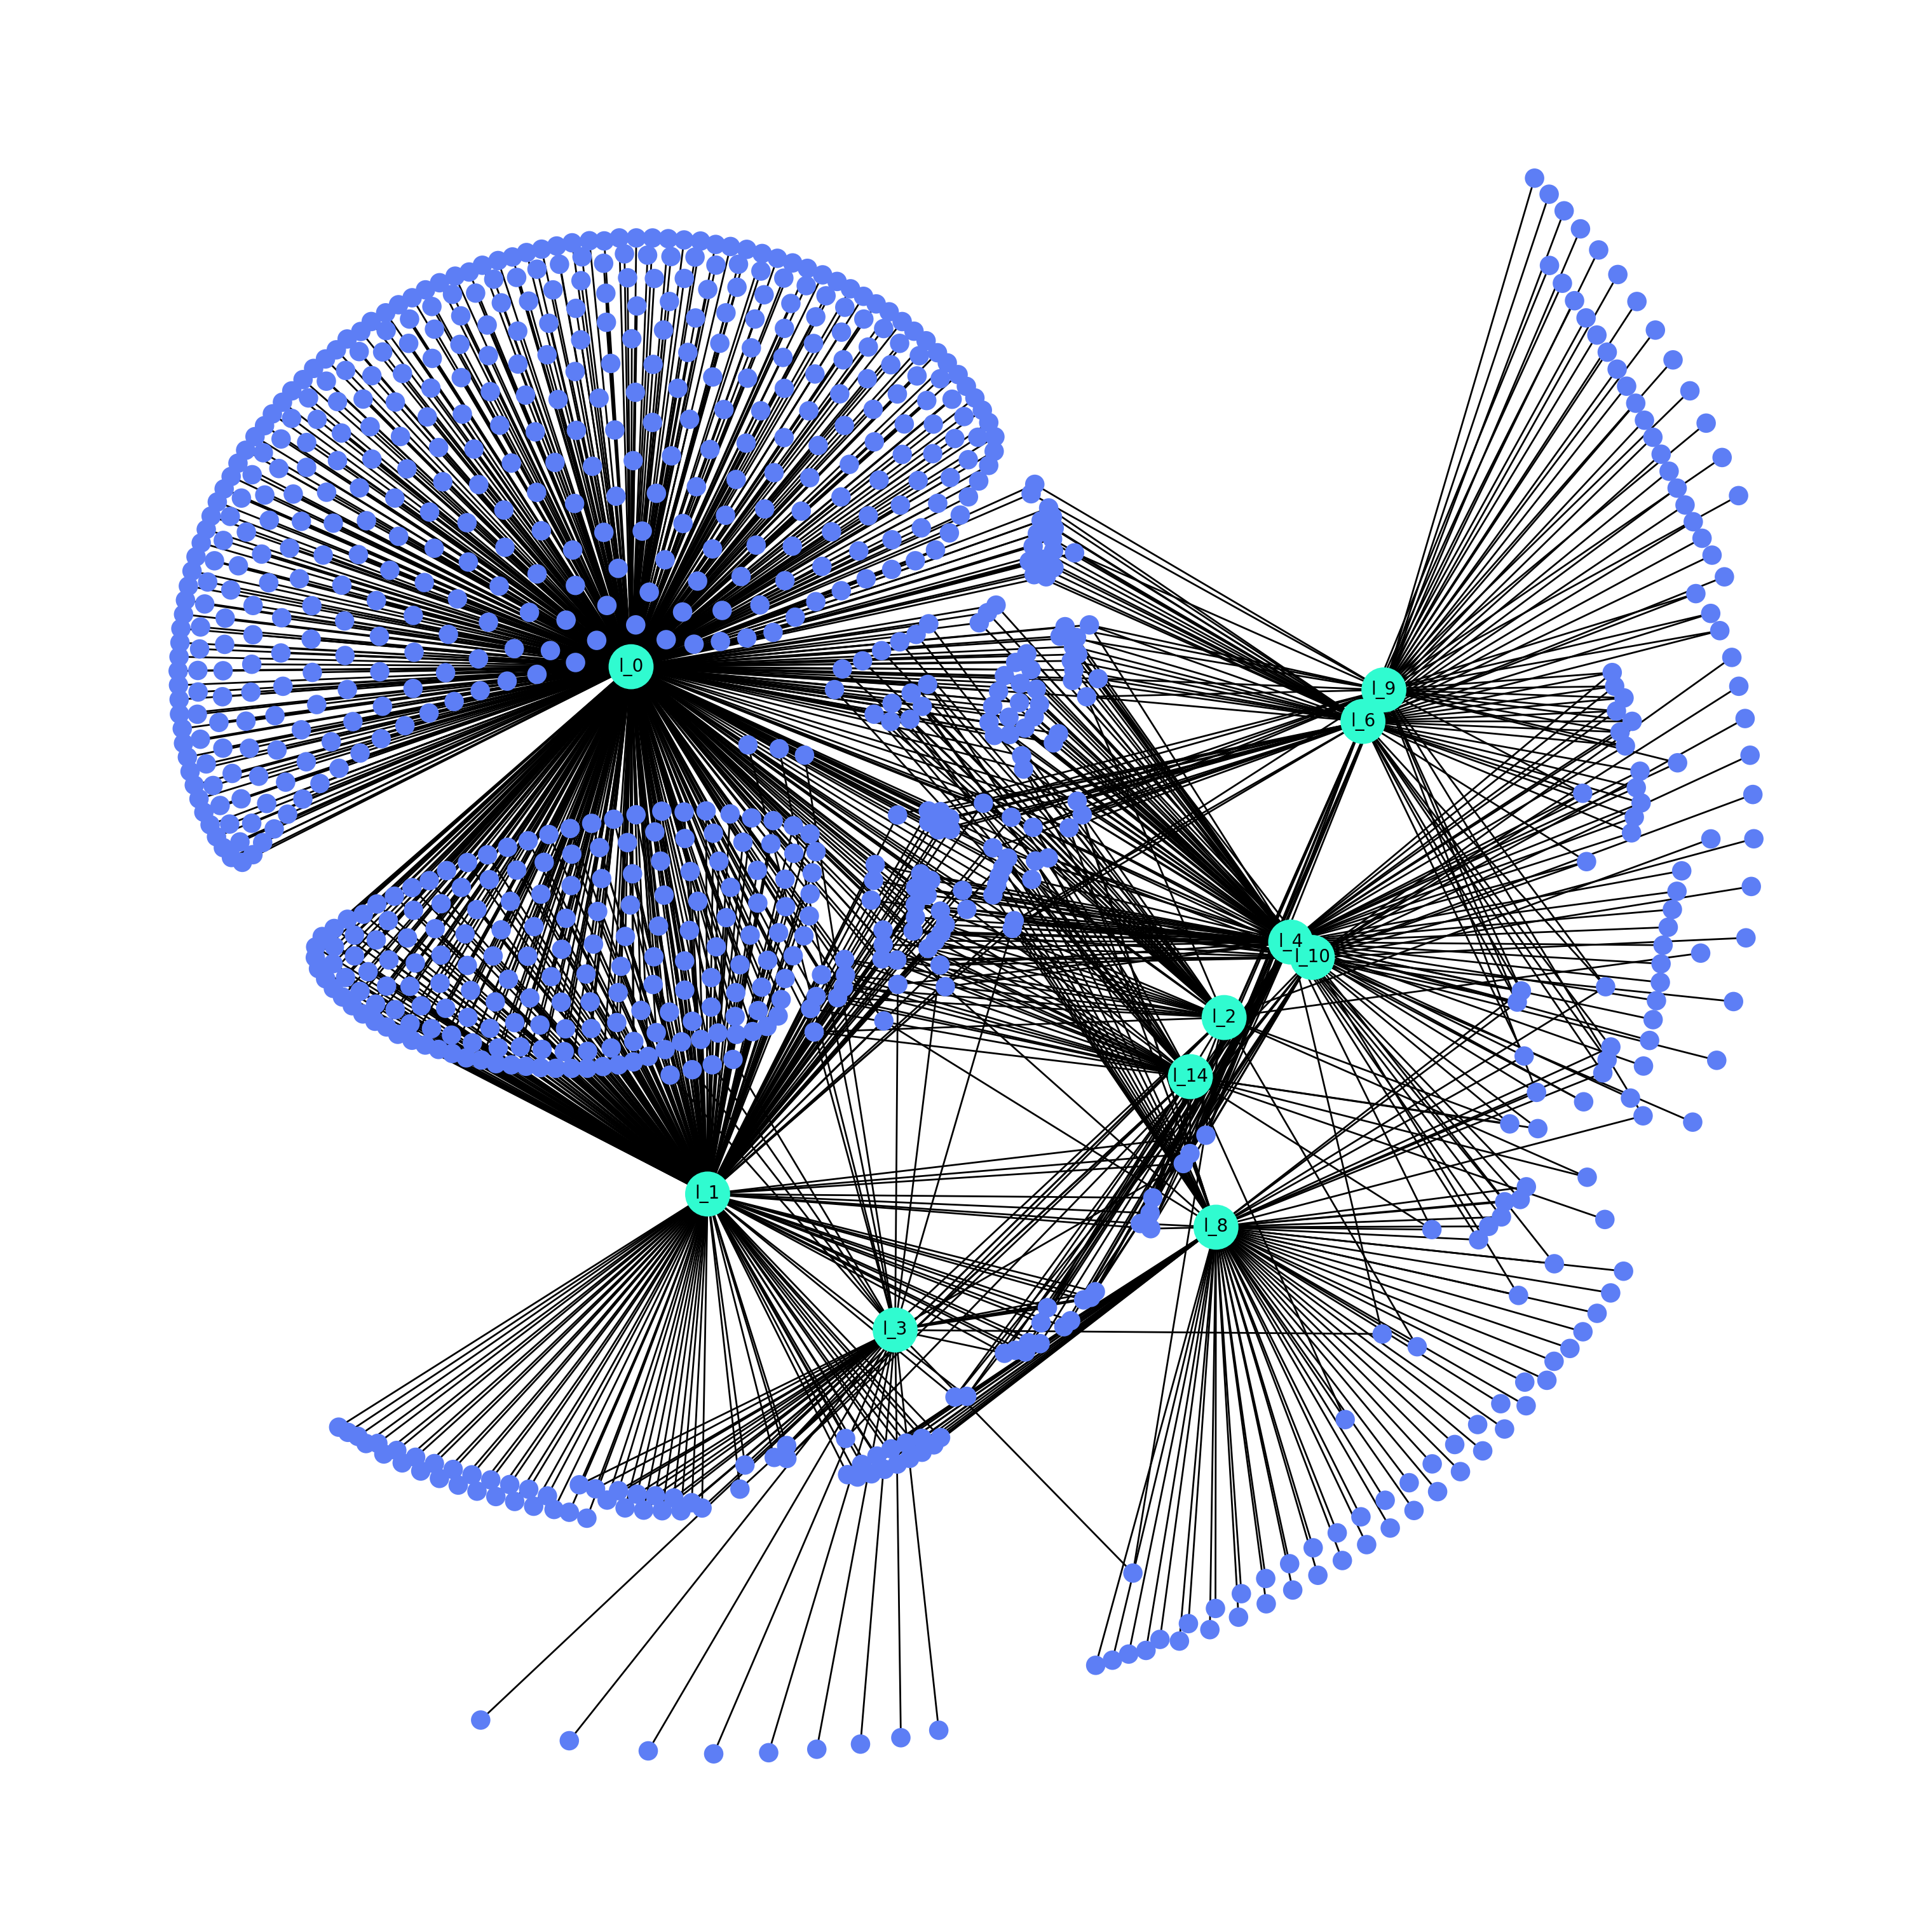

In [41]:
# Draw the graph containing only the top 5 languages with neighbours based on degree centrality
languages_subgraph = nx.Graph()
for node in sorted(languages_degree_centrality, key=languages_degree_centrality.get, reverse=True)[:10]:
    languages_subgraph.add_node(node, color = G.nodes[node]['color'])
    for neighbour in G.neighbors(node):
        if neighbour[0] == "l":
            languages_subgraph.add_node(neighbour, color = G.nodes[neighbour]['color'])
        else:
            languages_subgraph.add_node(neighbour, color = G.nodes[neighbour]['color'])
        languages_subgraph.add_edge(node, neighbour)

plt.figure(num=None, figsize=(15, 15), dpi=200)
pos = nx.kamada_kawai_layout(languages_subgraph)
node_sizes = [600 if node.startswith('l_') else 100 for node in languages_subgraph.nodes]
nx.draw(languages_subgraph, pos, node_size=node_sizes, node_color=[languages_subgraph.nodes[node]['color'] for node in languages_subgraph.nodes])
labels = {node: node for node in languages_subgraph.nodes if node.startswith('l_')}
nx.draw_networkx_labels(languages_subgraph, pos, labels, font_size=10)

### Modularity


In [58]:
#calculate modularity to find user comunites based on languages used in different repositories
partition = community.best_partition(G)
modularity = community.modularity(partition, G)

# Print the modularity of the graph
print("\nModularity of the graph:", modularity)

AttributeError: module 'community' has no attribute 'best_partition'

### Structural equivalence




Number of structural equivalence classes: {frozenset({'r_162', 'r_643', 'r_781', 'r_970'}), frozenset({'r_504'}), frozenset({'r_790', 'r_1106', 'r_815', 'r_827', 'r_269', 'r_953', 'r_130', 'r_1084', 'r_726', 'r_1086', 'r_461'}), frozenset({'r_499', 'r_1112', 'r_603', 'r_495', 'r_876', 'r_184', 'r_993', 'r_1068', 'r_1022', 'r_399', 'r_776', 'r_978', 'r_39', 'r_1020', 'r_298', 'r_492', 'r_337', 'r_232', 'r_218', 'r_490', 'r_1113', 'r_617', 'r_518', 'r_166', 'r_974', 'r_639', 'r_567', 'r_1114', 'r_33', 'r_529', 'r_934', 'r_208', 'r_287', 'r_73', 'r_420', 'r_11', 'r_809', 'r_1080', 'r_784', 'r_394', 'r_462', 'r_764', 'r_941', 'r_397', 'r_742', 'r_1002', 'r_110', 'r_889', 'r_404', 'r_525', 'r_129', 'r_481', 'r_1026', 'r_84', 'r_636', 'r_935', 'r_3', 'r_1137', 'r_875', 'r_446', 'r_794', 'r_233', 'r_59', 'r_387', 'r_646', 'r_147', 'r_1101', 'r_565', 'r_125', 'r_10', 'r_926', 'r_849', 'r_551', 'r_167', 'r_818', 'r_138', 'r_882', 'r_619', 'r_1011', 'r_1000', 'r_17', 'r_973', 'r_1065', 'r_389',

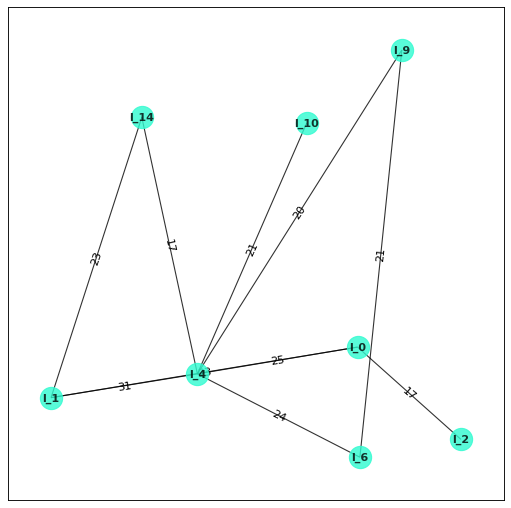

In [43]:
#calculare structural equivalence classes
def same_langs(repo1, repo2):
    langs1 = set(G.nodes[repo1]['languages'])
    langs2 = set(G.nodes[repo2]['languages'])
    return langs1 == langs2

repos = [r for r in G.nodes if r.startswith('r_')]
structural_equivalence = nx.equivalence_classes(repos, same_langs)

# Print the number of structural equivalence classes
print("\nNumber of structural equivalence classes:", structural_equivalence)

# Ottieni le combinazioni di linguaggi utilizzati insieme
lang_combinations = {}
for equiv_class in structural_equivalence:
    lang_set = set()
    for repo in equiv_class:
        lang_set.update(set(G.nodes[repo]['languages']))
    for combo in combinations(lang_set, 2):
        lang_combinations[combo] = lang_combinations.get(combo, 0) + 1

# Stampa le 5 combinazioni di linguaggi più utilizzate
top_combinations = sorted(lang_combinations.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 5 language combinations:")
for combo, count in top_combinations:
    print(combo, count)

#creazione del grafo
G_langs = nx.Graph()
for combo, count in top_combinations:
    lang1, lang2 = combo
    G_langs.add_edge(lang1, lang2, weight=count)

# layout e visualizzazione del grafo
plt.figure(num=None, figsize=(8, 8), dpi=80)
pos = nx.spring_layout(G_langs, k=0.90, iterations=1)

edge_weights = nx.get_edge_attributes(G_langs, 'weight')
nx.draw_networkx_edge_labels(G_langs, pos, edge_labels=edge_weights, font_size=10)
nx.draw_networkx(G_langs, pos, with_labels=True, node_size=400, node_color='#30FBD0', width=1, alpha=0.8, font_size=10, font_color='black', font_weight='bold')

Combinazioni di linguaggi più utilizzati escludendo l_4 Shell


Number of structural equivalence classes: {frozenset({'r_162', 'r_643', 'r_781', 'r_970'}), frozenset({'r_504'}), frozenset({'r_790', 'r_1106', 'r_815', 'r_827', 'r_269', 'r_953', 'r_130', 'r_1084', 'r_726', 'r_1086', 'r_461'}), frozenset({'r_499', 'r_1112', 'r_603', 'r_495', 'r_876', 'r_184', 'r_993', 'r_1068', 'r_1022', 'r_399', 'r_776', 'r_978', 'r_39', 'r_1020', 'r_298', 'r_492', 'r_337', 'r_232', 'r_218', 'r_490', 'r_1113', 'r_617', 'r_518', 'r_166', 'r_974', 'r_639', 'r_567', 'r_1114', 'r_33', 'r_529', 'r_934', 'r_208', 'r_287', 'r_73', 'r_420', 'r_11', 'r_809', 'r_1080', 'r_784', 'r_394', 'r_462', 'r_764', 'r_941', 'r_397', 'r_742', 'r_1002', 'r_110', 'r_889', 'r_404', 'r_525', 'r_129', 'r_481', 'r_1026', 'r_84', 'r_636', 'r_935', 'r_3', 'r_1137', 'r_875', 'r_446', 'r_794', 'r_233', 'r_59', 'r_387', 'r_646', 'r_147', 'r_1101', 'r_565', 'r_125', 'r_10', 'r_926', 'r_849', 'r_551', 'r_167', 'r_818', 'r_138', 'r_882', 'r_619', 'r_1011', 'r_1000', 'r_17', 'r_973', 'r_1065', 'r_389',

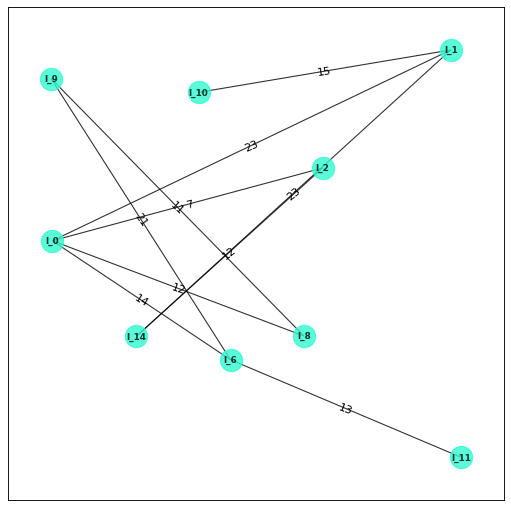

In [44]:
#calculare structural equivalence classes
def same_langs(repo1, repo2):
    langs1 = set(G.nodes[repo1]['languages'])
    langs2 = set(G.nodes[repo2]['languages'])
    return langs1 == langs2

repos = [r for r in G.nodes if r.startswith('r_')]
structural_equivalence = nx.equivalence_classes(repos, same_langs)

# Print the number of structural equivalence classes
print("\nNumber of structural equivalence classes:", structural_equivalence)

# Ottieni le combinazioni di linguaggi utilizzati insieme 
lang_combinations = {}
for equiv_class in structural_equivalence:
    lang_set = set()
    for repo in equiv_class:
        lang_set.update(set(G.nodes[repo]['languages']))
    for combo in combinations(lang_set, 2):
        if 'l_4' not in combo:
            lang_combinations[combo] = lang_combinations.get(combo, 0) + 1

# Stampa le 5 combinazioni di linguaggi più utilizzate
top_combinations = sorted(lang_combinations.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 5 language combinations:")
for combo, count in top_combinations:
    print(combo, count)

#creazione del grafo
G_langs = nx.Graph()
for combo, count in top_combinations:
    lang1, lang2 = combo
    if lang1 != 'l_4' and lang2 != 'l_4':
        G_langs.add_edge(lang1, lang2, weight=count)


# layout e visualizzazione del grafo
plt.figure(num=None, figsize=(8, 8), dpi=80)
pos = nx.spring_layout(G_langs, k=0.90, iterations=1)

edge_weights = nx.get_edge_attributes(G_langs, 'weight')
nx.draw_networkx_edge_labels(G_langs, pos, edge_labels=edge_weights, font_size=10)
nx.draw_networkx(G_langs, pos, with_labels=True, node_size=400, node_color='#30FBD0', width=1, alpha=0.8, font_size=8, font_color='black', font_weight='bold')

### Cores

In [45]:
# create a subgraph with only 'repository' and 'user' nodes
subgraph_nodes = [n for n in G.nodes if n.startswith(('r', 'u'))]
# create edges between users and repositories
user_repo_edges = [(u, v) for (v, u) in G.edges if u.startswith('u_') and v.startswith('r_')]
subgraph = G.subgraph(subgraph_nodes)

#nx.edges(subgraph)
#print(subgraph.nodes.data())

In [46]:
degree_centrality = nx.degree_centrality(subgraph)
#split degree centrality in repositories 
repos_degree_centrality = {k: v for k, v in degree_centrality.items() if k.startswith('r_')}

print("\nDegree centrality of first 10 users in descending order:")
for node in sorted(repos_degree_centrality, key=repos_degree_centrality.get, reverse=True)[:10]:
    print(node, repos_degree_centrality[node])

# Print mean degree centrality for users
print("\nMean degree centrality:", sum(repos_degree_centrality.values())/len(repos_degree_centrality))



Degree centrality of first 10 users in descending order:
r_318 0.007823613086770981
r_872 0.006401137980085349
r_195 0.005689900426742532
r_785 0.004978662873399715
r_14 0.004267425320056899
r_32 0.004267425320056899
r_201 0.004267425320056899
r_271 0.004267425320056899
r_743 0.0035561877667140826
r_267 0.002844950213371266

Mean degree centrality: 0.0002360357021216921


In [47]:
repo_sub= nx.Graph()
repo_sub = subgraph.subgraph([node for node in subgraph.nodes() if node.startswith('r')])
repo_subgraph_copy = repo_sub.copy()

# Add edges between nodes with the same number of stars
for node1 in repo_subgraph_copy.nodes():
    n_stars1 = int(repo_subgraph_copy.nodes[node1]['n_star'])
    for node2 in repo_subgraph_copy.nodes():
        n_stars2 = int(repo_subgraph_copy.nodes[node2]['n_star'])
        if n_stars1 == n_stars2 and node1 != node2:
            repo_subgraph_copy.add_edge(node1, node2)

#nx.info(repo_subgraph_copy)
#print(repo_subgraph_copy.data())
core_number = nx.core_number(repo_subgraph_copy)
#print languages of the nodes
#print(repo_subgraph_copy.nodes.data('languages'))
#print(core_number)
k_core = nx.k_core(repo_subgraph_copy, k=2)
#print (k_core)
# Recupera i primi 10 k-core
top_k_core = sorted(set(core_number.values()), reverse=True)[:2]

                

In [48]:
repo_sub = subgraph.subgraph([node for node in subgraph.nodes() if node.startswith('r')])
repo_subgraph_copy = nx.Graph(repo_sub)
# Add edges between nodes with the same number of stars
for node1 in repo_subgraph_copy.nodes():
    n_stars1 = int(repo_subgraph_copy.nodes[node1]['n_star'])
    for node2 in repo_subgraph_copy.nodes():
        n_stars2 = int(repo_subgraph_copy.nodes[node2]['n_star'])
        if n_stars1 == n_stars2 and node1 != node2:
            repo_subgraph_copy.add_edge(node1, node2)
# Get core numbers of nodes
core_number = nx.core_number(repo_subgraph_copy)
# Create k-core of highest value
k = sorted(set(core_number.values()), reverse=True)[1]
k_core_nodes = [node for node, core in core_number.items() if core >= k]
k_core = repo_subgraph_copy.subgraph(k_core_nodes)
# Get language count of nodes in k-core
language_count = {}
for node in k_core.nodes():
    languages = k_core.nodes[node].get('languages', [])
    for language in languages:
        if language != '':
            language_count[language] = language_count.get(language, 0) + 1

sorted_languages = sorted(language_count.items(), key=lambda x: x[1], reverse=True)
# Print top languages
print(f"Top languages in k-core {k}:")
for language, count in sorted_languages[:5]:
    print(f"{language}: {count}")
    #print("Repositories in the k-core:")
    #for repo in repos:
    #    print(repo)


Top languages in k-core 113:
l_0: 287
l_1: 143
l_4: 55
l_8: 41
l_6: 40
l_9: 32
l_10: 27
l_3: 20
l_18: 16
l_13: 12


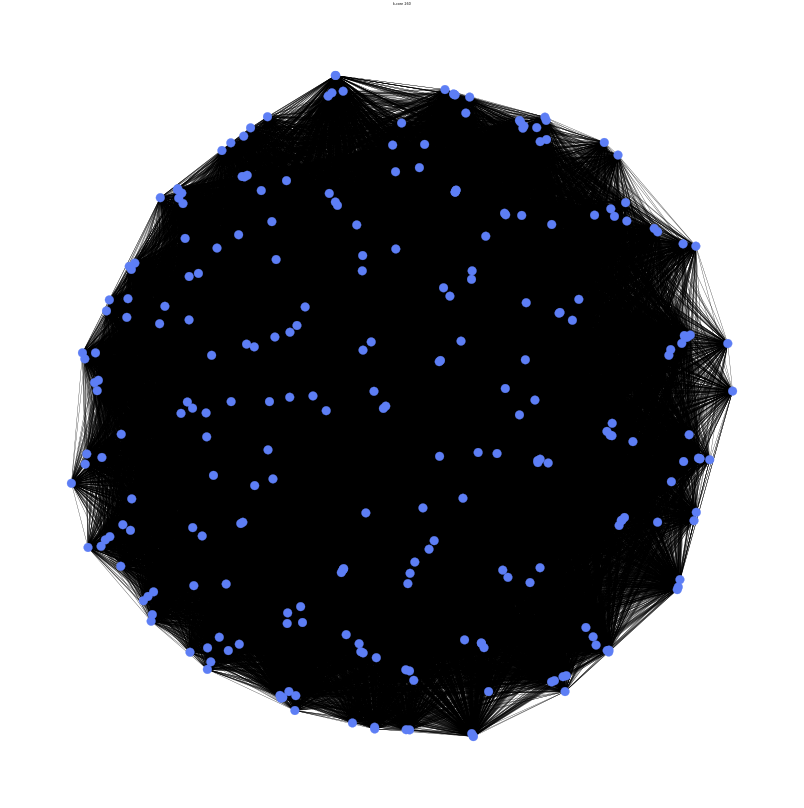

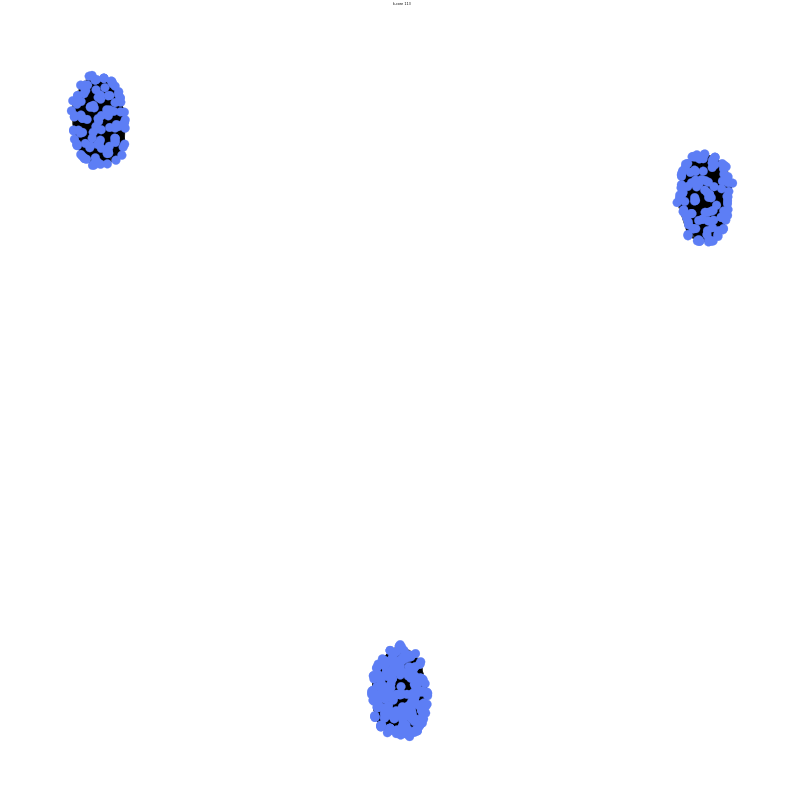

In [51]:
# Disegna il grafo per ogni k-core in top_k_core
for k in top_k_core:
    k_core_nodes = [node for node, core in core_number.items() if core >= k]
    k_core = repo_subgraph_copy.subgraph(k_core_nodes)
    plt.figure(num=None, figsize=(40, 40), dpi=20)
    nx.draw(k_core, with_labels=False, node_size=1000, node_color=[k_core.nodes[node]['color'] for node in k_core.nodes])
    plt.title(f"k-core {k}")
    plt.show()



### Homophily

Capire se gli utenti che frequentano la piattaforma tendono a collaborare con altri utenti che sviluppano dei progetti simili tra loro, per esempio utilizzano lo stesso linguaggio di programmazione ed inoltre cercare di capire se utenti connessi tra di loro utilizzano dei topics nelle repository.

In [52]:
# create a subgraph with only 'repository' and 'user' nodes
subgraph_nodes = [n for n in G.nodes if n.startswith(('u', 'r'))]
# create edges between users and repositories
user_repo_edges = [(u, v) for (v, u) in G.edges if u.startswith('u_') and v.startswith('r_')]
subgraph_ru = G.subgraph(subgraph_nodes)

In [53]:
# crea un sottografo con i nodi utente
user_nodes = [n for n in G.nodes if n.startswith("u")]
subgraph = G.subgraph(user_nodes).copy()

# aggiungi gli archi tra utenti che hanno contribuito alla stessa repository
for repo_node in subgraph_ru.nodes:
    # se il nodo corrente è una repository
    if repo_node.startswith("r"):
        # crea un insieme di utenti che hanno contribuito alla repository corrente
        repo_users = set(subgraph_ru.neighbors(repo_node)).intersection(user_nodes)
        # crea gli archi tra le coppie di utenti che hanno contribuito alla stessa repository
        subgraph.add_edges_from(combinations(repo_users,2))


In [54]:
# crea un dizionario vuoto per gli attributi dei nodi degli utenti nel sottografo
user_attrs = {}

for user_node in subgraph.nodes():
    #create a set of repositories that the user has contributed 
    user_repos = set(n for n in subgraph_ru.neighbors(user_node) if n.startswith("r"))
    languages = set()
    topics = set()
    for repo_node in user_repos:
        languages |= set(subgraph_ru.nodes[repo_node]['languages'])
        topics |= set(subgraph_ru.nodes[repo_node]['topics'])
    #add languages and topics to users attributes
    user_attrs[user_node] = {'languages': list(languages), 'topics': list(topics)}

# add attributes to nodes
nx.set_node_attributes(subgraph, user_attrs)
#nx.get_node_attributes(subgraph, 'languages')


In [55]:
# take only the lanuages most used 
for node in subgraph.nodes:
    if node.startswith('u_') and subgraph.nodes[node]['languages'] != []:
        max_lang = subgraph.nodes[node]['languages'][0]
        subgraph.nodes[node]['languages'] = ' '.join(subgraph.nodes[node]['languages'])

lan_hom = nx.attribute_assortativity_coefficient(subgraph, 'languages')
print ("Languages homophily:", lan_hom)

Languages homophily: 0.5583362732463119


In [56]:
for node in subgraph.nodes:
    if node.startswith('u_') and subgraph.nodes[node]['topics'] != []:
        max_lang = subgraph.nodes[node]['topics'][0]
        subgraph.nodes[node]['topics'] = ' '.join(subgraph.nodes[node]['topics'])

top_hom = nx.attribute_assortativity_coefficient(subgraph, 'topics')
print ("Topics homophily:", top_hom)

Topics homophily: 0.7175534559920433
